In [1]:
# Import libraries
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
import os
from tqdm import tqdm
import numpy as np
import fiona
import pandas as pd
from shapely.strtree import STRtree
from shapely.geometry import Point as SPoint

## Part I: Creating our Graph

#### File-Paths
Understanding shapefiles: [Link](https://www.geowgs84.com/post/understanding-shapefiles-a-deep-dive-into-shp-dbf-shx-and-prj)

- `.shp`: points, lines and polygons; encoded in binary, ebgin with a fixed-length header and each feature then has its own header and content.
- `.shx`: spatial indexing - acts as an index for the `.shp` file - speeds up queries. Has fixed length records pointing to corresponding feature locations     
- `.prj`: projection file - contains the coordinate system and projection of our shapes
- `.dbf`: databased file - contains attribute data per shape - columns like name, population, elevation and the like.

Alternatives we may see: 
- GeoJSON 
- GPKG - Geopackage

*GeoPandas can be used for all vector files. Rasterio for all raster images*


In [2]:
DATA_DIRECTORY = "data"
# Effis Fire Dataset - European Forest Fire Information System
# https://forest-fire.emergency.copernicus.eu/applications/data-and-services
FIRE_DATA_PATH = os.path.join(DATA_DIRECTORY, "fire_data/modis.ba.poly.shp")

# Several TIFFs with Wildfire Severity, once again from Effis
WILDFIRE_SEVERITY_DIR = os.path.join(DATA_DIRECTORY, "wildfire_severity")

# Natural Earth - public domain dataset of global geography
# Admin 0 – Countries dataset has country boundaries
# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
COUNTRY_BOUNDARY_PATH = os.path.join(DATA_DIRECTORY, "country_boundaries/ne_110m_admin_0_countries.shp")

# Hydro River Network Database
RIVERS_PATH = os.path.join(DATA_DIRECTORY, "rivers", "euhydro_tajo_v013.gdb")

# Create a data_plots directory
DATA_PLOTS_DIRECTORY = 'data_plots'
os.makedirs(DATA_PLOTS_DIRECTORY, exist_ok=True)

# Create output directory for Portugal grid shapefile
OUTPUT_DIRECTORY = 'output'
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

##### Coordinate reference system - defines how spatial data coordinates relate to the earth. Defines origin, units, orientation

In [3]:
coord_ref_sys = "EPSG:25829"

### Filter out to our target area: 

Functions to load the fire data of the country we are aiming for, as well as the polygon and bounds of that country

In [4]:
from preprocessing.load_data import load_fire_data

fire_data = load_fire_data(fire_data_path=FIRE_DATA_PATH, coord_ref_sys=coord_ref_sys)

Loaded fire dataset with 3597 unique fires


In [5]:
from preprocessing.load_data import extract_polygon, cut_size

mainland, mainland_polygon, minx, miny, maxx, maxy = extract_polygon(
    country_boundary_dataset_path=COUNTRY_BOUNDARY_PATH, country="Portugal", coord_ref_sys=coord_ref_sys)
minx, miny, maxx, maxy = cut_size(minx, miny, maxx, maxy, decrease_bottom=0.5, decrease_top=0.15, decrease_left=0,
                                  decrease_right=0)

Country bounds minx: 454235.1439060115, miny: 4077542.239783567, maxx: 718319.3451133408, maxy: 4681179.434351782
New minx: 454235.1439060115, new miny: 4590633.85516655, new maxx: 718319.3451133408, new maxy: 4590633.85516655


In [6]:
from preprocessing.load_data import create_grid

grid_size = 3000
grid = create_grid(grid_size, mainland_polygon, coord_ref_sys, minx, miny, maxx, maxy)
grid.head()  # each entry is lower-left, upper-left, upper-right, lower-right, lower-left points of each square

Successfully created grid!
Num nodes = 3924


,geometry
0,"POLYGON ((484235.144 4379360.837, 484235.144 4..."
1,"POLYGON ((487235.144 4379360.837, 487235.144 4..."
2,"POLYGON ((487235.144 4382360.837, 487235.144 4..."
3,"POLYGON ((490235.144 4379360.837, 490235.144 4..."
4,"POLYGON ((490235.144 4382360.837, 490235.144 4..."


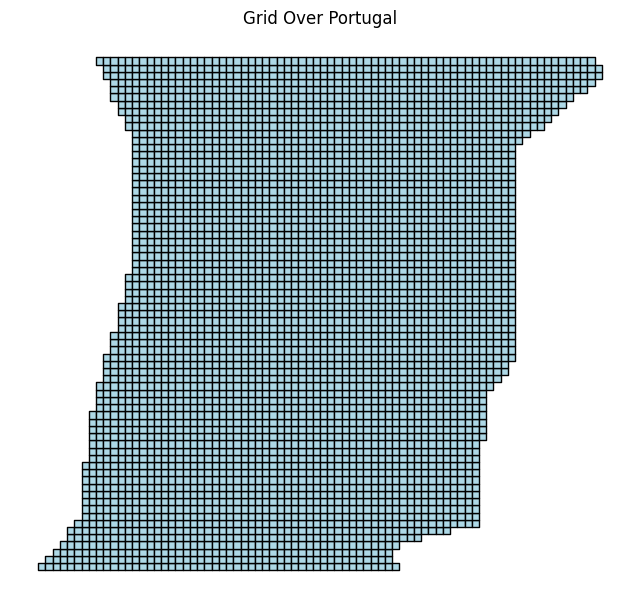

In [7]:
from visualization.preprocessing_visualization import plot_grid_to_be_used

plot_name_grid = "portugal_grid_plot.png"
plot_grid_to_be_used(grid, DATA_PLOTS_DIRECTORY, plot_name_grid, "Grid Over Portugal")

In [8]:
# saving observation area as shapefile and gpkg for better visualization in QGIS
grid.to_file(os.path.join(OUTPUT_DIRECTORY, "portugal_grid.shp"))
grid.to_file(os.path.join(OUTPUT_DIRECTORY, "portugal_grid.gpkg"), layer="grid", driver="GPKG")

grid["centroid_grid"] = grid.geometry.centroid

In [9]:
from preprocessing.enrich_data import add_water_to_grid

# List of layer indices we need for our river dataset
layer_indices = [0, 1, 6, 8, 9]
grid = add_water_to_grid(grid, coord_ref_sys, RIVERS_PATH, layer_indices)

Combined water bodies: (41321, 52)


In [10]:
grid = grid.reset_index(drop=True)
grid["node_id"] = np.arange(len(grid))

#### Overlay with Fire Data

Assumption - if a grid square centroid overlaps with a fire point - the node corresponding to said grid square centroid is on fire. We want to make this into a series, per date, for each fire.

In [11]:
from preprocessing.enrich_data import extract_fire_day, extract_fire_centroids

fire_data = extract_fire_centroids(fire_data)
fire_data = extract_fire_day(fire_data)

### Clustering for weather data

In [12]:
from preprocessing.cluster import give_cluster_grid_centers

n_clusters = 50
cluster_grid_centers, grid = give_cluster_grid_centers(n_clusters, grid, coord_ref_sys)

(np.int64(2641), <POINT (620735.144 4509860.836)>)
(np.int64(178), <POINT (515735.144 4437860.836)>)
(np.int64(586), <POINT (533735.144 4521860.836)>)
(np.int64(1977), <POINT (593735.144 4434860.836)>)
(np.int64(3208), <POINT (644735.144 4578860.836)>)
(np.int64(1103), <POINT (554735.144 4581860.836)>)
(np.int64(3563), <POINT (662735.144 4467860.836)>)
(np.int64(2001), <POINT (593735.144 4506860.836)>)
(np.int64(3634), <POINT (665735.144 4521860.836)>)
(np.int64(1337), <POINT (566735.144 4431860.836)>)
(np.int64(2160), <POINT (599735.144 4557860.836)>)
(np.int64(1820), <POINT (587735.144 4389860.836)>)
(np.int64(1850), <POINT (587735.144 4479860.836)>)
(np.int64(131), <POINT (512735.144 4413860.836)>)
(np.int64(506), <POINT (530735.144 4494860.836)>)
(np.int64(3891), <POINT (695735.144 4581860.836)>)
(np.int64(2530), <POINT (617735.144 4389860.836)>)
(np.int64(954), <POINT (548735.144 4560860.836)>)
(np.int64(3358), <POINT (653735.144 4437860.836)>)
(np.int64(774), <POINT (542735.144 4

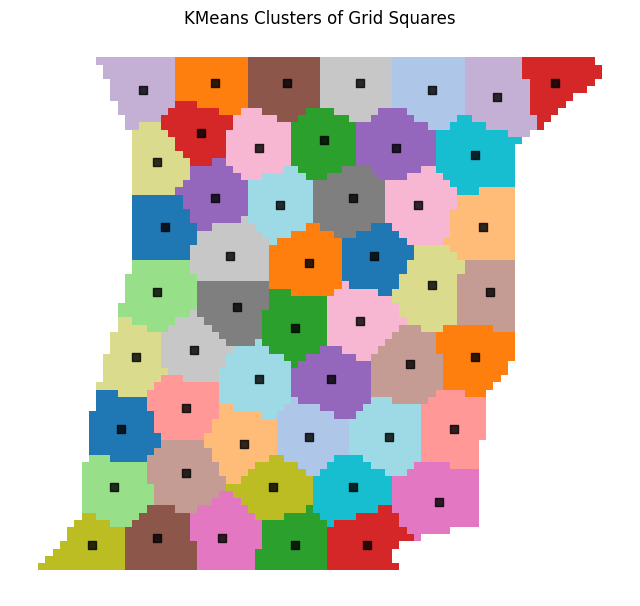

In [13]:
from visualization.preprocessing_visualization import show_clusters

show_clusters(grid, coord_ref_sys, cluster_grid_centers, DATA_PLOTS_DIRECTORY, "kmeans_clusters_grid.png")

### Aggregate Grid Based on Day

In [40]:
from preprocessing.enrich_data import split_graphs_into_days
import pickle

cache_file = "data/graphs_per_day.pkl"

if os.path.exists(cache_file):
    print("Cache file exists, loading it...")
    with open(cache_file, "rb") as f:
        graphs = pickle.load(f)
else:
    print("No cached file found, downloading...")
    graphs = split_graphs_into_days(grid, fire_data, fire_data["DAY"].unique(), WILDFIRE_SEVERITY_DIR,
                                    cluster_grid_centers)
    with open("data/graphs_per_day.pkl", "wb") as f:
        pickle.dump(graphs, f)
    print("Successfully wrote cached file to", cache_file)

Cache file exists, loading it...


In [39]:
from types import GeneratorType
from typing import List


def _materialize_or_placeholder(x, to="tuple", on_error="nan"):
    """Turn generators into concrete values; fall back safely on errors."""
    if isinstance(x, GeneratorType):
        try:
            seq = list(x)  # consume generator once
            # collapse trivial shapes, e.g. [[value]] -> value
            if len(seq) == 1 and isinstance(seq[0], (list, tuple, np.ndarray)):
                arr = np.asarray(seq[0])
                if arr.size == 1:
                    return float(arr.ravel()[0])
            return tuple(seq) if to == "tuple" else list(seq)
        except Exception as e:
            if on_error == "nan":
                return np.nan
            if on_error == "none":
                return None
            if on_error == "repr":
                return f"<generator-error {type(x).__name__}: {e}>"
            # otherwise re-raise
            raise
    elif isinstance(x, dict):
        return {k: _materialize_or_placeholder(v, to, on_error) for k, v in x.items()}
    elif isinstance(x, (list, tuple, set)):
        seq = [_materialize_or_placeholder(v, to, on_error) for v in x]
        if isinstance(x, tuple): return tuple(seq)
        if isinstance(x, set):   return set(seq)
        return seq
    return x


def make_picklable_graphs(graphs: List[pd.DataFrame],
                          to="tuple",
                          on_error="nan",
                          verbose=True):
    """
    Recursively replaces any generators in DataFrame attrs or object columns.
    - to: "tuple" or "list" for materialized generators
    - on_error: "nan" | "none" | "repr" | "raise"
    """
    cleaned = []
    for gi, g in enumerate(graphs):
        g = g.copy()

        # Clean DataFrame attrs (attrs are pickled too)
        if getattr(g, "attrs", None):
            for k, v in list(g.attrs.items()):
                g.attrs[k] = _materialize_or_placeholder(v, to, on_error)

        # Clean object-dtype columns (GeoDataFrame geometry isn't object dtype)
        obj_cols = g.select_dtypes(include=["object"]).columns
        gen_hits = 0
        for c in obj_cols:
            # count generators quickly
            mask = g[c].map(lambda v: isinstance(v, GeneratorType))
            gen_hits += int(mask.sum())
            if gen_hits:
                # replace generators safely
                g.loc[mask, c] = g.loc[mask, c].map(lambda v: _materialize_or_placeholder(v, to, on_error))
                # also run through other object entries to catch nested gens
                others = ~mask
                if others.any():
                    g.loc[others, c] = g.loc[others, c].map(lambda v: _materialize_or_placeholder(v, to, on_error))

        if verbose and gen_hits:
            print(f"[graphs[{gi}]] replaced {gen_hits} generator cells")

        cleaned.append(g)

    return cleaned


graphs_clean = make_picklable_graphs(graphs, to="tuple")


# sanity check: no generators left
def _assert_no_generators(graphs):
    for i, g in enumerate(graphs):
        pickle.dumps(g)


_assert_no_generators(graphs_clean)

with open("data/graphs_per_day.pkl", "wb") as f:
    pickle.dump(graphs_clean, f)

[graphs[342]] replaced 3 generator cells
[graphs[344]] replaced 2 generator cells
[graphs[346]] replaced 6 generator cells
[graphs[347]] replaced 4 generator cells
[graphs[348]] replaced 13 generator cells
[graphs[350]] replaced 2 generator cells
[graphs[352]] replaced 2 generator cells
[graphs[353]] replaced 39 generator cells
[graphs[354]] replaced 2 generator cells
[graphs[355]] replaced 6 generator cells
[graphs[360]] replaced 2 generator cells
[graphs[361]] replaced 6 generator cells
[graphs[362]] replaced 27 generator cells
[graphs[363]] replaced 11 generator cells
[graphs[365]] replaced 6 generator cells
[graphs[366]] replaced 7 generator cells
[graphs[367]] replaced 2 generator cells
[graphs[369]] replaced 8 generator cells
[graphs[370]] replaced 17 generator cells
[graphs[376]] replaced 2 generator cells
[graphs[377]] replaced 8 generator cells
[graphs[378]] replaced 8 generator cells
[graphs[379]] replaced 2 generator cells
[graphs[382]] replaced 19 generator cells
[graphs[38

In [15]:
df = graphs[0]
df

,dist_to_water,node_id,PROVINCE,BROADLEA,CONIFER,MIXED,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,...,DAY,has_fire,fire_intensity,tavg,tmin,tmax,prcp,wspd,pres,FireSeason
0,9366.776304,0,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
1,7024.423788,1,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
2,7587.118789,2,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
3,4022.630401,3,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
4,4895.181952,4,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,91463.864312,3919,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False
3920,93926.132309,3920,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False
3921,96418.506215,3921,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False
3922,89720.357593,3922,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False


## Convert to .npy format with one feature (number of wildfires)

#### Make node order identical for timeseries_data and A

In [17]:
# Create a node index
node_index = (grid[["node_id"]]
              .drop_duplicates()
              .sort_values("node_id")
              .set_index("node_id")
              .index)

assert grid.crs and not grid.crs.is_geographic, "Grid must be in a projected CRS (meters)."

# Reorder grid_gdf to this canonical order so the distance matrix uses the same row order
grid = (grid
        .drop_duplicates(subset="node_id")
        .set_index("node_id")
        .loc[node_index]
        .reset_index())

assert grid["node_id"].is_unique, "node_id must be unique after dedup."

#### Distance Matrix

In [18]:
from preprocessing.export_data import export_distance_matrix

export_distance_matrix(grid)

Saved distance matrix as data/distance_matrix.npy


In [19]:
graphs[0]

,dist_to_water,node_id,PROVINCE,BROADLEA,CONIFER,MIXED,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,...,DAY,has_fire,fire_intensity,tavg,tmin,tmax,prcp,wspd,pres,FireSeason
0,9366.776304,0,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
1,7024.423788,1,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
2,7587.118789,2,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
3,4022.630401,3,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
4,4895.181952,4,NaN,0,0,0,0,0,0,0,...,NaN,0,0,30.3,20.0,39.1,0.0,12.8,12.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,91463.864312,3919,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False
3920,93926.132309,3920,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False
3921,96418.506215,3921,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False
3922,89720.357593,3922,NaN,0,0,0,0,0,0,0,...,NaN,0,0,28.0,19.5,36.1,0.0,6.6,6.6,False


#### Timeseries Data

In [27]:
# Construct Timeseries Data
# Concatenate all days into one long table (keep only what we need)

from preprocessing.export_data import construct_timeseries_data

construct_timeseries_data(graphs)

Index(['dist_to_water', 'node_id', 'PROVINCE', 'BROADLEA', 'CONIFER', 'MIXED',
       'TRANSIT', 'OTHERNATLC', 'AGRIAREAS', 'ARTIFSURF', 'OTHERLC',
       'PERCNA2K', 'DAY', 'has_fire', 'fire_intensity', 'tavg', 'tmin', 'tmax',
       'prcp', 'wspd', 'pres', 'FireSeason', '30DAYS', '7DAYS'],
      dtype='object')
[nan datetime.date(2016, 8, 8) datetime.date(2016, 8, 11)
 datetime.date(2016, 9, 5) datetime.date(2016, 8, 22)
 datetime.date(2016, 8, 14) datetime.date(2016, 8, 10)
 datetime.date(2016, 8, 7) datetime.date(2016, 9, 6)
 datetime.date(2016, 10, 6) datetime.date(2016, 8, 15)
 datetime.date(2016, 9, 7) datetime.date(2016, 8, 9)
 datetime.date(2016, 8, 6) datetime.date(2016, 9, 8)
 datetime.date(2016, 8, 2) datetime.date(2016, 9, 1)
 datetime.date(2016, 10, 8) datetime.date(2016, 8, 28)
 datetime.date(2016, 7, 29) datetime.date(2016, 7, 26)
 datetime.date(2016, 8, 21) datetime.date(2016, 8, 20)
 datetime.date(2016, 8, 13) datetime.date(2016, 8, 23)
 datetime.date(2016, 7, 31) dat

ValueError: cannot reshape array of size 110845152 into shape (3924,571,22)

In [20]:
# Final sanity checks for adjacency matrices
N = len(node_index)
assert A.shape == (N, N), "Distance matrix shape mismatch."
assert np.allclose(A, A.T), "Distance matrix must be symmetric."
assert timeseries_data.shape[0] == N, "Timeseries row count must match nodes."
assert np.isfinite(timeseries_data).all(), "Timeseries contains non-finite values."

NameError: name 'A' is not defined

## Clustering grid squares in terms of weather data to reduce number of API calls

### Original Fire Attributes
- **`id`** → Unique identifier for each fire record.  
- **`FIREDATE`** → Date and time when the fire occurred.  
- **`LASTUPDATE`** → Timestamp of the last update for the fire record.  
- **`COUNTRY`** → Country where the fire occurred.  
- **`PROVINCE`** → Province of the fire location.  
- **`COMMUNE`** → Commune (local administrative area) of the fire.  
- **`AREA_HA`** → Burned area in hectares.  

### Land Cover / Fire Area Composition
- **`BROADLEA`** → Proportion of broadleaf vegetation in the fire area.  
- **`CONIFER`** → Proportion of coniferous vegetation.  
- **`MIXED`** → Proportion of mixed forest.  
- **`SCLEROPH`** → Proportion of sclerophyllous vegetation (e.g., Mediterranean shrubs).  
- **`TRANSIT`** → Proportion of transitional land cover.  
- **`OTHERNATLC`** → Proportion of other natural land cover.  
- **`AGRIAREAS`** → Proportion of agricultural areas.  
- **`ARTIFSURF`** → Proportion of artificial surfaces (urban/industrial).  
- **`OTHERLC`** → Proportion of other land cover types.  
- **`PERCNA2K`** → Percentage of area under special designation (e.g., Natura 2000).  
- **`CLASS`** → Fire classification or severity category.  

### Fire Geometry / Location
- **`geometry`** → Original fire geometry (polygon or point).  
- **`centroid_x_fire`** → X coordinate of fire centroid.  
- **`centroid_y_fire`** → Y coordinate of fire centroid.  

### Spatial Join with Grid Cells
- **`index_right`** → Index of the grid cell containing the fire centroid (NaN if none).  
- **`centroid_grid`** → Geometry of the grid cell centroid.  
- **`centroid_x_grid`** → X coordinate of the grid cell centroid.  
- **`centroid_y_grid`** → Y coordinate of the grid cell centroid.  
- **`has_fire`** → Boolean indicating if the fire is inside a grid cell.  

### Time-Based Helper
- **`DAY`** → Date only (no time), extracted from `FIREDATE`, used for grouping fires by day.
